# Delineation of Ferpecles Glacier Contours Across time

The Ferpècles glacier is melting.

We use the Copernicus' Sentinel 2 data to denileat the glaciers and estimate its surface. Follow along as we authenticate to the server and download the data.

First, let us import all the necessary libraries.

In [385]:
import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import geopandas as gpd
import json
from ipyleaflet import Map, GeoJSON, basemaps, Rectangle

from sentinelhub import (
    SHConfig,
    Geometry,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    MosaickingOrder,
    BBox,
    CRS,
    bbox_to_dimensions
)
DATA_PATH  = "../data/ferpecles/"

## Connection to Copernicus
A connection to the Copernicus servers is necessary to request new data. Copernicus uses Oauth2 to authenticate to the servers; it requires a token, which is received after authentication with a `client_id` and `client_secret`. Tho obtain these latter follow the documentation [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html). The `SHConfig` class of `sentinelhub` manages this under the hood. The `client_id` and `client_secret`, are typically stored as a profile in a local `config.toml` file.

If the data has been previously obtained and is in the data folder, the `profile` argument of `SHConfig` can be ommitted as no connection to the server will be established in this case.

In [386]:
config = SHConfig(profile="copernicus") # loads my profile to download data, change for your own profile. The `config.toml` file is in config.get_config_location()
# config = SHConfig()  # If data is already in DATA_PATH, no profile is needed and you can replace the above line by this
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"


### Defining the contours of the area of interest
We can define the contours of the area of interest by using a shape defined in the `ferpecles.geojson` file. Custom `geojson` files can easily be created on (geojson.io).

Note: Here, we need to be careful about the units. THe units of geometry with WGS84 are degrees. To get a 20m resolution, the geometry must be transformed to EPSG:3035.

In [387]:
# Load the GeoJSON into a GeoDataFrame and JSON objects
ferpecles_gdf = gpd.read_file("ferpecles.geojson").to_crs("EPSG:3035") # GeoDataFrame (gdf) allows for spatial operations and is useful for analysis. See above note.
ferpecles_geometry = Geometry(geometry=ferpecles_gdf.geometry.values[0], crs=ferpecles_gdf.crs) 
ferpecles_data = json.load(open("ferpecles.geojson", "r")) # JSON is often used in APIs an web apps

## Plotting the map and layer
To plot the image we need a center and a zoom level.

In [434]:
# Compute the centroid
center = [46.02, 7.55] # [latitude, longitude]
zoom = 12
map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)


# Add the GeoDataFrame as a GeoJSON layer

geo_json_layer = GeoJSON(data=ferpecles_json, style={"color": "blue", "opacity": 0.7, "weight": 2})
map.add_layer(geo_json_layer)

# Display the map
map

Map(center=[46.02, 7.55], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

## Requesting Sentinel-2 Data
Here we request all bands, and we additionally add scene classification (SCL). Once the request is defined, it can be used to get the actual data. It will look in the `data_folder` to get the data from there; if it doesn't exist it will use the `config` object to access the servers and download it.

### 1. Define the create_request function to create our custom request.

To write the evalscript refer to [the docs](https://docs.sentinel-hub.com/api/latest/evalscript/v3/).

In [390]:
def create_request(geometry, time_interval, config, data_folder):
    """
    Creates a Sentinel Hub request for satellite imagery data.

    Parameters:
    - geometry (Geometry): The area of interest as a geometry object.
    - time_interval (tuple): Time range for the data request, formatted as ('YYYY-MM-DD', 'YYYY-MM-DD').
    - config (SHConfig): Configuration object for Sentinel Hub, including API keys and other settings.
    - data_folder (str): File path for storing the downloaded data.

    Returns:
    - SentinelHubRequest: A configured request object for Sentinel Hub API.
    """
    
    # Script executed on Sentinel Hub that defines the output format and content
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "SCL", "dataMask"]
            }],
            output: [{
                id: "default",
                bands: 13,
                sampleType: "AUTO"
            }]
        };
    }

    function evaluatePixel(sample) {
        return {
            default: [sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06,
                      sample.B07, sample.B08, sample.B8A, sample.B11, sample.B12, sample.SCL, sample.dataMask]
        };
    }
    """

    # Constructing the Sentinel Hub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "s2l2a", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        geometry=geometry,
        resolution=(20, 20),
        config=config,
        data_folder=data_folder
    )

    return request


### 2. Define time intervals for the request

In [391]:
# Define month intervals 
start_date = datetime.datetime(2018,6,1)
end_date = datetime.datetime.today()

current_date = start_date

time_intervals = []
while current_date < end_date:
    # If current month is December, set month_end_date to the start of January next year
    if current_date.month == 12:
        month_end_date = datetime.datetime(current_date.year + 1, 1, 1)
    else:
        # Otherwise, set month_end_date to the start of the next month
        month_end_date = datetime.datetime(current_date.year, current_date.month + 1, 1)

    # Don't append the interval if there's less than 15 days to end_date
    if end_date - current_date < datetime.timedelta(15):
        break
    
    time_intervals.append((current_date.isoformat(), month_end_date.isoformat()))
    current_date = month_end_date

# Print the intervals
print(f'A total of {len(time_intervals)} time intervals were created.\
    \nFirst interval:{time_intervals[0]}\
    \nLast interval: {time_intervals[-1]}.')

A total of 65 time intervals were created.    
First interval:('2018-06-01T00:00:00', '2018-07-01T00:00:00')    
Last interval: ('2023-10-01T00:00:00', '2023-11-01T00:00:00').


### 3. Create the requests for all time intervals

In [392]:

all_requests = []

for time_interval in time_intervals:
    request = create_request(geometry=ferpecles_geometry, time_interval=time_interval, config=config, data_folder=DATA_PATH)
    all_requests.append(request)


### 4. Download the data for all requests

Download all data; get_data() will either download and save the data if none is present in the `DATA_PATH` folder, or it will load it from there.
The returned element is a numpy array.

In [393]:
data = [request.get_data(save_data=True)[0] for request in all_requests]
data = np.stack(data, axis=0)

# standardize data by dividing by the max of each band
data = data.astype(np.float32) # standardize the imagaes
data = data / np.max(data, axis=(0,1,2)).reshape(1,1,1,-1)

Plot the images

Using Normalized Difference Snow Inde (NDSI)

$$
NDSI = \frac{Green - SWIR}{Green + SWIR}
$$

The Green channel is B03 (idx 2) and the SWIR channel is B11 (idx 9) or B12 (idx 10)

High values of NDSI ( close to 1) indicate the presence of snow or ice. Low values (close to -1) suggests the absence of snow or ice.

First, let's check the distribution of the values of the corresponding bands:

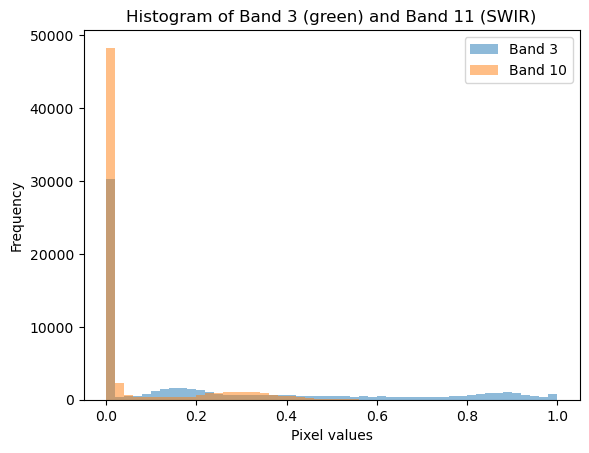

In [394]:
import matplotlib.pyplot as plt

# Assuming 'image' is a 3D numpy array where the third dimension represents different bands

# Plot histogram of the third band
plt.hist(data[-1, :, :, 2].flatten(), bins=50, alpha=0.5, label='Band 3')

# Plot histogram of the tenth band
plt.hist(data[-1, :, :, 9].flatten(), bins=50, alpha=0.5, label='Band 10')

plt.legend(loc='upper right')
plt.xlabel('Pixel values')
plt.ylabel('Frequency')
plt.title('Histogram of Band 3 (green) and Band 11 (SWIR)')
plt.show()


That seems good enough. Notice that a lot of the zeroes are the unsampled pixels in the image. Let's check the distribution of the NDSI values, to determine an appropriate cutoff. Because of the possible 0 in the denominator, we add a small number in both the numerator and denominator to compute the NDSI.

(array([2.000000e+00, 1.000000e+01, 4.300000e+01, 1.370000e+02,
        4.880000e+02, 2.406000e+03, 9.853000e+03, 1.705500e+04,
        1.967100e+04, 2.014000e+04, 1.927700e+04, 1.730900e+04,
        1.722400e+04, 1.888500e+04, 2.261000e+04, 2.768200e+04,
        3.097300e+04, 2.708400e+04, 1.869900e+04, 1.404500e+04,
        9.294000e+03, 8.132000e+03, 7.457000e+03, 7.129000e+03,
        6.983000e+03, 6.699000e+03, 6.838000e+03, 6.964000e+03,
        7.516000e+03, 8.133000e+03, 8.610000e+03, 9.068000e+03,
        9.687000e+03, 1.068000e+04, 1.145600e+04, 1.253400e+04,
        1.439100e+04, 2.033600e+04, 2.846700e+04, 3.289800e+04,
        5.044900e+04, 7.804000e+04, 9.205100e+04, 9.177300e+04,
        1.541690e+05, 1.857610e+05, 2.938530e+05, 2.533890e+05,
        3.848220e+05, 2.081578e+06]),
 array([-0.58017039, -0.548567  , -0.5169636 , -0.48536018, -0.45375675,
        -0.42215335, -0.39054996, -0.35894653, -0.32734314, -0.29573971,
        -0.26413631, -0.2325329 , -0.20092949, -

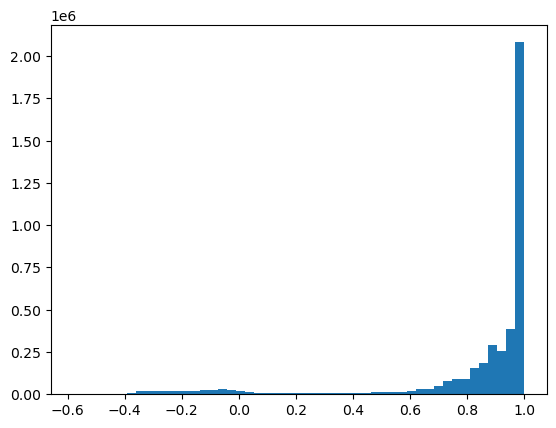

In [395]:
NDSI = (data[:, :,:,2] - data[:, :,:,9] + .05)/(data[:,:,:,2] + data[:, :,:,9] + .05)
plt.hist(NDSI.flatten(), bins=50)

In [396]:
NDSI.shape

(65, 325, 198)

A cutoff at 0.4 seems appropriate for our purpose.

## Plot image against the NDSI index

Here we only consider the months of July.

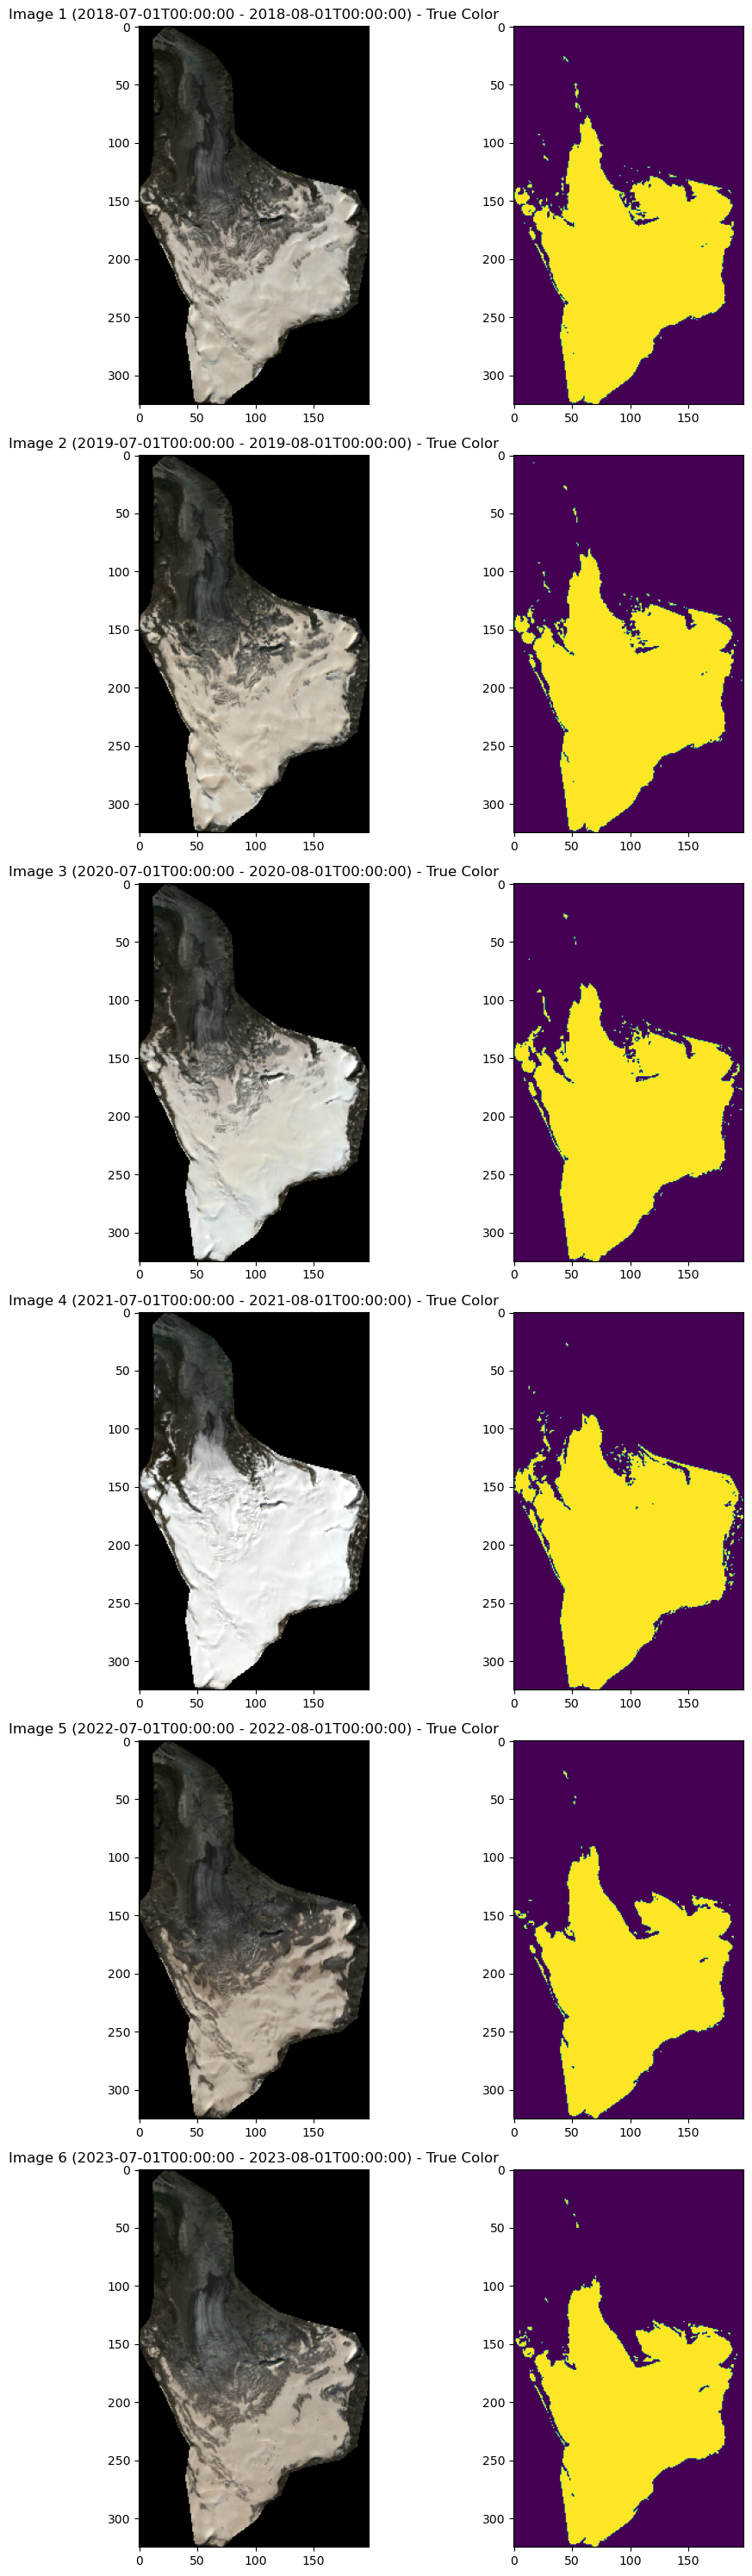

In [401]:
# Sample data for demonstration
idx = np.arange(1, data.shape[0], 12)  # 2nd month is july

fig, axs = plt.subplots(idx.shape[0], 2)
fig.set_size_inches(10., 5.*idx.shape[0])


# Loop through each image and display its true color representation
for i, idx_i in enumerate(idx):
    # Extract RGB bands
    red_channel = data[idx_i, :, :, 3]   # B04
    green_channel = data[idx_i, :, :, 2] # B03
    blue_channel = data[idx_i, :, :, 1]  # B02

    # Stack them together
    true_color_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

    axs[i, 0].imshow(true_color_image)
    
    # Set title with date information
    axs[i, 0].set_title(f"Image {i + 1} ({time_intervals[idx_i][0]} - {time_intervals[idx_i][1]}) - True Color")

    # Plot NDSI
    NDSI_image = NDSI[idx_i]>0.4
    mask = data[idx_i, :,:,-1]
    NDSI_image[mask<.5] = 0.
    axs[i, 1].imshow(NDSI_image)


plt.tight_layout()
plt.show()


### Time series of estimated snow surface

Text(0.5, 1.0, 'Proportion of snow coverage across time.')

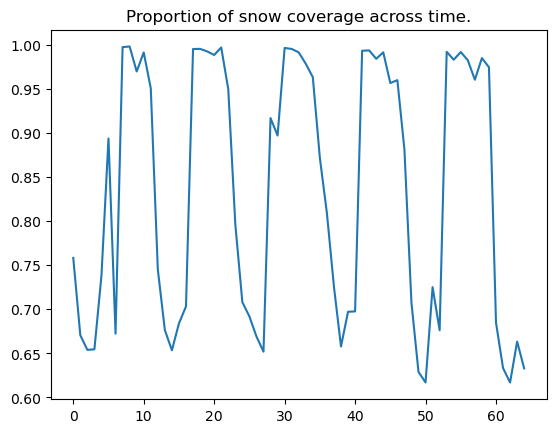

In [427]:
ice = NDSI > 0.4
mask = data[:,:,:,-1] > .5 # True if the pixel is sampled
ice[~mask] = 0.

surface = np.sum(ice, axis=(1,2)) / np.sum(mask, axis=(1,2))
plt.plot(surface)
plt.title("Proportion of snow coverage across time.")

So we learn that snow melts in summer.